# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering, DBSCAN, SpectralClustering
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer

# Loading Dataset

In [2]:
df = pd.read_csv("../data/[CLEANED]kepler-data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(9110, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Selecting Columns for Analysis

We eliminate all the columns that are either of the following
* Assigned after other values are measured from readings
* Contain ID or name attributes
* Are error attributes

There are namely [6 types](http://www.sun.org/encyclopedia/exoplanets) of exoplanets

In [3]:
ALL_COLUMNS = df.columns
ERROR_COLUMNS = [col for col in ALL_COLUMNS if "err" in col]
EXCLUDE = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", "koi_tce_delivname", "koi_tce_plnt_num"] + ERROR_COLUMNS
TO_USE = list(set(ALL_COLUMNS) - set(EXCLUDE))

In [4]:
print(len(TO_USE))
df[TO_USE].head()

19


,ra,koi_impact,koi_steff,koi_srad,koi_fpflag_co,koi_kepmag,koi_fpflag_ec,koi_fpflag_nt,koi_depth,koi_duration,koi_prad,koi_period,koi_time0bk,koi_fpflag_ss,koi_insol,koi_teq,koi_slogg,dec,koi_model_snr
0,291.93423,0.146,5455.0,0.927,0,15.347,0,0,615.8,2.95750,2.26,9.488036,170.538750,0,93.59,793.0,4.467,48.141651,35.8
1,291.93423,0.586,5455.0,0.927,0,15.347,0,0,874.8,4.50700,2.83,54.418383,162.513840,0,9.11,443.0,4.467,48.141651,25.8
2,297.00482,0.969,5853.0,0.868,0,15.436,0,0,10829.0,1.78220,14.60,19.899140,175.850252,1,39.30,638.0,4.544,48.134129,76.3
3,285.53461,1.276,5805.0,0.791,0,15.597,0,0,8079.2,2.40641,33.46,1.736952,170.307565,1,891.96,1395.0,4.564,48.285210,505.6
4,288.75488,0.701,6031.0,1.046,0,15.509,0,0,603.3,1.65450,2.75,2.525592,171.595550,0,926.16,1406.0,4.438,48.226200,40.9


# Extracting Dataframe Subset

We extract only those rows which are `CONFIRMED` examples i.e. the `disposition value` is `CONFIRMED`.

In [5]:
new_df = df[df["koi_disposition"] == "CONFIRMED"]
print(new_df.shape)
new_df.head()

(2292, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
5,6,10872983,K00756.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
6,7,10872983,K00756.02,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


# Extracting Values

In [6]:
X = new_df[TO_USE].values
y = new_df["koi_disposition"].values

In [7]:
X_scaler = StandardScaler()
X_scaler.fit(X)
X_scaled = X_scaler.transform(X)

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_2d = pca.transform(X_scaled)

In [8]:
X_2d.shape

(2292, 2)

# Visualisation

In [9]:
def elbowVisualiser(model, metric=None):
    if metric is None:
        visualizer = KElbowVisualizer(model, k=(4,12))
    else:
        visualizer = KElbowVisualizer(model, k=(4,12), metric=metric)
    visualizer.fit(X)
    visualizer.show(f"{model}_elbow.png", dpi=600)
    
    
def interclusterDistanceVisualisation(model):
    visualizer = InterclusterDistance(model)
    visualizer.fit(X)
    visualizer.show(f"{model}_inter_cluster_dist.png", dpi=600)
    

def silhouetteVisualisation(model):
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(X)
    visualizer.show(f"{model}_ss.png", dpi=600)
    
    
def viewKMeansScatter(model):
    clust_labels = model.predict(X)
    temp_df = new_df[TO_USE].copy()
    temp_df["Class"] = clust_labels
    unique_classes = list(range(model.n_clusters))
    print(temp_df.groupby("Class").median())
    plt.grid()
    for cls in unique_classes:
        sub_df = temp_df[temp_df["Class"] == cls]
        temp_X = sub_df[[col for col in temp_df.columns if col != "Class"]].values
        temp_X_2d = pca.transform(X_scaler.transform(temp_X))
        plt.grid()
        #print(X_2d.shape)    
        plt.scatter(temp_X_2d[:, 0], temp_X_2d[:, 1], label=cls)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.savefig("scatter.png", dpi=600)
    return temp_df.groupby("Class").median()
    
def viewAggScatter(model):
    clust_labels = model.fit_predict(X)
    temp_df = new_df[TO_USE].copy()
    temp_df["Class"] = clust_labels
    unique_classes = list(range(model.n_clusters))
    print(temp_df.groupby("Class").median())
    plt.grid()
    for cls in unique_classes:
        sub_df = temp_df[temp_df["Class"] == cls]
        temp_X = sub_df[[col for col in temp_df.columns if col != "Class"]].values
        temp_X_2d = pca.transform(X_scaler.transform(temp_X))
        #print(X_2d.shape)    
        plt.grid()
        plt.scatter(temp_X_2d[:, 0], temp_X_2d[:, 1], label=cls)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.show()
    plt.savefig(f"agg_scatter_{model}.png", dpi=600)
    
def getVisualisationPCA(X, y):
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X)
    
    pca_df = pd.DataFrame(
        data = principal_components,
        columns = ['principal component 1', 'principal component 2']
    )
    
    pca_df["TARGET"] = y
    labels = np.unique(y)
    
    colors = cm.plasma(np.linspace(0, 1, len(labels)))
    plt.grid()
    for label, color in zip(labels, colors):
        indicesToKeep = pca_df['TARGET'] == label
        plt.scatter(
            pca_df.loc[indicesToKeep, 'principal component 1'],
            pca_df.loc[indicesToKeep, 'principal component 2'],
            c = color,
            label=label
        )
        
    plt.legend()
    plt.grid()            

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


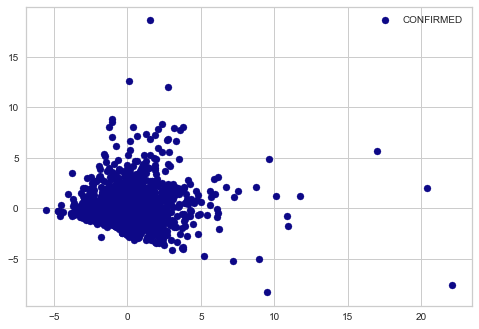

In [10]:
getVisualisationPCA(X, y)

# KMeans Clustering

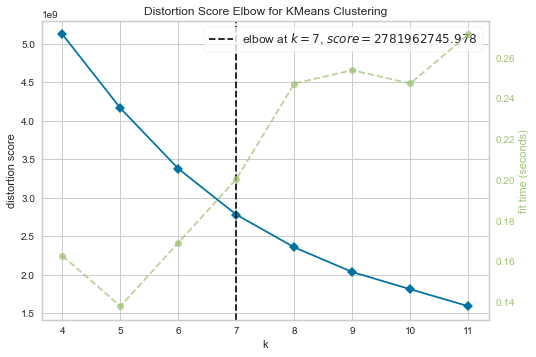

In [11]:
model = KMeans(random_state=0)
elbowVisualiser(model)

In [12]:
K=7
model = KMeans(K, max_iter=500, random_state=0)
model.fit(X)

KMeans(max_iter=500, n_clusters=7, random_state=0)

               ra  koi_impact  koi_steff  koi_srad  koi_fpflag_co  koi_kepmag  \
Class                                                                           
0      291.256200      0.4145     5779.0    1.0490            0.0     14.2710   
1      292.658420      0.2160     5510.0    0.7930            0.0     15.1270   
2      290.922210      0.2535     5742.0    1.2470            0.0     14.1155   
3      292.242020      0.2695     5779.0    1.1065            0.0     14.7035   
4      285.367630      0.7250     7606.0    2.6675            0.0     11.7025   
5      290.465120      0.4030     4827.0    0.7070            0.0     15.0840   
6      291.927745      0.3635     5546.5    0.9140            0.0     14.9380   

       koi_fpflag_ec  koi_fpflag_nt  koi_depth  koi_duration  koi_prad  \
Class                                                                    
0                0.0            0.0     326.80      4.014200     2.090   
1                0.0            0.0   22335.00  

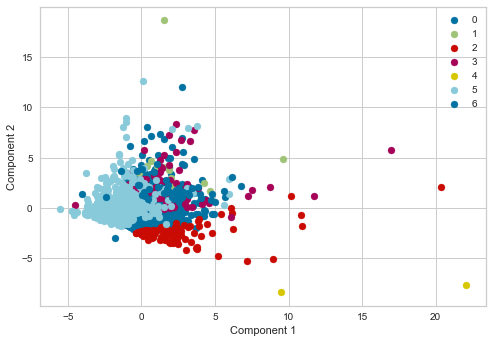

In [13]:
t=viewKMeansScatter(model)

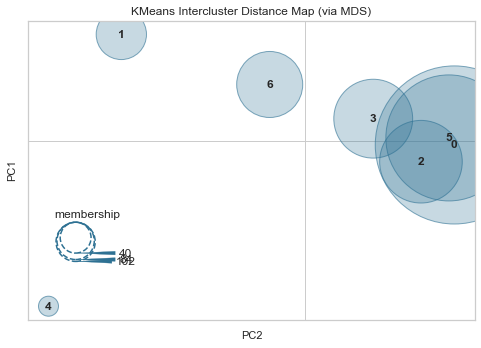

In [14]:
interclusterDistanceVisualisation(model)

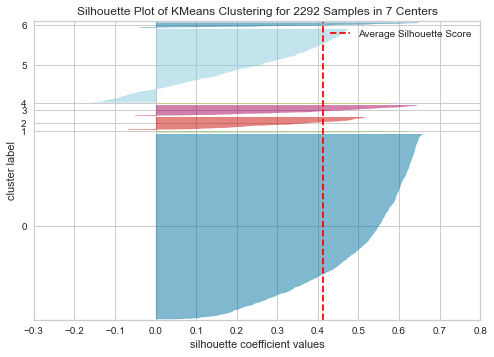

In [15]:
silhouetteVisualisation(model)

# Agglomerative Clustering

In [22]:
def plot_dendrogram(X):
    de = dendrogram(linkage(X, method='ward'))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.grid()
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")  
    plt.savefig("dendogram.png", dpi=600)

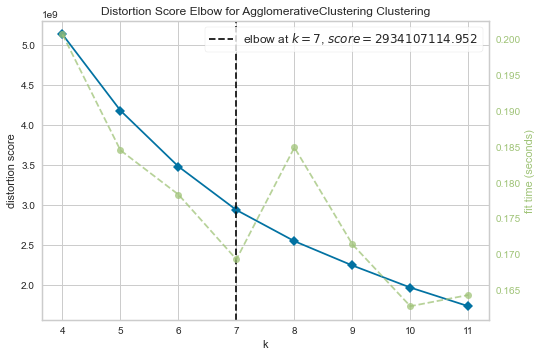

In [17]:
model = AgglomerativeClustering()
elbowVisualiser(model)

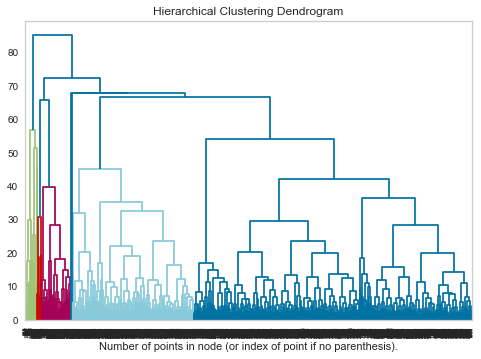

In [23]:
plot_dendrogram(X_scaled)

               ra  koi_impact  koi_steff  koi_srad  koi_fpflag_co  koi_kepmag  \
Class                                                                           
0      292.287320       0.284     5758.0    1.0810            0.0     14.6510   
1      290.693730       0.271     5718.0    1.2500            0.0     14.1130   
2      290.954850       0.421     5052.0    0.7850            0.0     15.0305   
3      285.367630       0.725     7606.0    2.6675            0.0     11.7025   
4      292.658420       0.216     5510.0    0.7930            0.0     15.1270   
5      291.220125       0.404     5850.0    1.0935            0.0     14.1380   
6      292.579860       0.407     5532.0    0.9000            0.0     15.0110   

       koi_fpflag_ec  koi_fpflag_nt  koi_depth  koi_duration  koi_prad  \
Class                                                                    
0                0.0            0.0    6674.70      4.301000      9.11   
1                0.0            0.0     150.20  

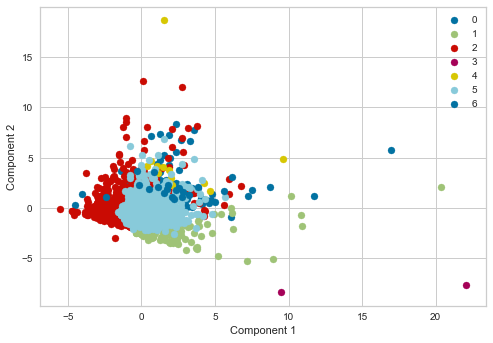

<Figure size 576x396 with 0 Axes>

In [24]:
K=7
model = AgglomerativeClustering(n_clusters=K)
viewAggScatter(model)

# Obtaining Trends

In [20]:
t.head()

,ra,koi_impact,koi_steff,koi_srad,koi_fpflag_co,koi_kepmag,koi_fpflag_ec,koi_fpflag_nt,koi_depth,koi_duration,koi_prad,koi_period,koi_time0bk,koi_fpflag_ss,koi_insol,koi_teq,koi_slogg,dec,koi_model_snr
Class,,,,,,,,,,,,,,,,,,,
0,291.25620,0.4145,5779.0,1.0490,0.0,14.2710,0.0,0.0,326.80,4.014200,2.09,11.833289,139.513825,0.0,123.255,850.0,4.3940,44.518215,27.05
1,292.65842,0.2160,5510.0,0.7930,0.0,15.1270,0.0,0.0,22335.00,4.272100,12.19,3.905082,170.047995,0.0,67.300,730.0,4.5560,41.944069,1077.80
2,290.92221,0.2535,5742.0,1.2470,0.0,14.1155,0.0,0.0,152.55,1.935500,1.45,1.326078,132.476340,0.0,2391.165,1783.5,4.2595,44.089634,25.40
3,292.24202,0.2695,5779.0,1.1065,0.0,14.7035,0.0,0.0,5811.55,5.155675,8.97,19.721425,169.998236,0.0,34.675,619.0,4.3680,43.449030,285.85
4,285.36763,0.7250,7606.0,2.6675,0.0,11.7025,0.0,0.0,2325.80,2.152685,11.83,1.228283,126.183673,0.5,31099.550,3372.5,3.8360,44.545266,2041.40


In [21]:
t.std()

ra                   2.468743
koi_impact           0.171315
koi_steff          852.041002
koi_srad             0.667931
koi_fpflag_co        0.000000
koi_kepmag           1.200468
koi_fpflag_ec        0.000000
koi_fpflag_nt        0.000000
koi_depth         8428.570200
koi_duration         1.166409
koi_prad             4.966585
koi_period           7.060858
koi_time0bk         17.928517
koi_fpflag_ss        0.188982
koi_insol        11604.505149
koi_teq           1013.912337
koi_slogg            0.258292
dec                  1.031913
koi_model_snr      762.228749
dtype: float64